#  MEPS in the Invasion Game With Distraction

**Philip A. LeMaitre, Marius Krumm**

In this notebook, we will train Multi-Excitation Projective Simulation (MEPS) agents on a simple synthetic environment. We call this environment the **Invasion Game With Distraction**. 

In this reinforcement learning environment, the agent's observation is the value of each of three observables. The agent has to pick one of two doors depending on the values of the first two observables. The third observable is a useless distraction.

The point of this simplistic synthetic environment is to demonstrate the advantages provided by a good inductive bias on how many excitations can interact simultaneously in a MEPS agent. 

To keep the comparison clean, we sample the observations i.i.d., don't use glow or forgetting in the update rule, use harsh negative rewards of -10, which effectively prevents a hyperedge from being sampled again (except for the 1-body agent), and to each observation there is exactly one right deterministic action. Furthermore, we use the version of the inductive bias in which passive excitations get discarded, all agents are two-layered. 

The agents we compare use the inductive bias sets $IO = \{(1,1)\}$, $\{(2,1)\}$ and $\{(3,1)\}$, respectively. The $(1,1)$-agent is too simple to map the correlations of the first two observables to the right action. The $(2,1)$-agent has exactly the right inductive bias which allows it to ignore the distraction caused by the third observable. The $(3,1)$-agent is capable of solving the environment, but it is less efficient because all its h-values distinguish between different values of the distraction.  




In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import product, combinations
import torch
import seaborn as sns
import os
import sys


print("Python version:", sys.version)
print("Pytorch version:", torch.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

Python version: 3.9.16 (main, Mar  8 2023, 04:29:44) 
[Clang 14.0.6 ]
Pytorch version: 2.0.0
Numpy version: 1.23.5
Matplotlib version: 3.7.1
Seaborn version: 0.12.2


In [2]:
class InvasionGame():
    """
    Invasion Game With Distraction.
    """
    def __init__(self, obs0_range, obs1_range, obs2_range, action_range, seed):
        # Define domains for the values of the three observables. 
        # We will later choose all these domains to be range(10).
        self.obs0_range = obs0_range
        self.obs1_range = obs1_range
        self.obs2_range = obs2_range # Irrelevant percepts
        
        # Domain for the values of the action. Later chosen to be range(2).
        # The actions are a choice of a door.
        self.action_range = action_range
        self.rng = np.random.default_rng(seed) 
    
    

    def reset(self):
        """
        Resets the environment, generates and outputs a new percept, and internally stores the right answer.
        """
        # Uniformly sample the next percept/observation from the domains of the observables.
        self.obs_config = [self.rng.choice(self.obs0_range), self.rng.choice(self.obs1_range), self.rng.choice(self.obs2_range)]
        
        # Translate percept into an excitation configuration.
        # We use tuples to represent excitation configurations.
        # Excited clips are denoted in the form "obsO:V", with O the index of the observable,
        # and V the value of the observable.
        # The ordering convention is obs0 before obs1 before obs2.
        self.percept = ["obs0:"+str(self.obs_config[0]), "obs1:"+str(self.obs_config[1]), "obs2:"+str(self.obs_config[2])] 
        self.percept = tuple(self.percept)
        
        # To each percept, there is exactly one right answer.
        # To define a right answer that depends non-trivially on both of the first two observables,
        # and only takes values in {0,1}, we pick:
        self.right_answer = (self.obs_config[0]+self.obs_config[1]) % 2

        return self.percept
    
    

    def reward(self, action):
        """
        Calculates and outputs the reward given an action input.
        """
        # The reward is all-or-nothing: The agent only gets a positive reward for giving 
        # the right answer. For all other answers, the agent gets a severe negative reward.
        # For all agents except the 1-body agent, this severe negative reward essentially
        # prevents the corresponding h-value/transition from being sampled again.
        # This makes it easier to map the advantage in the number of trainable parameters
        # to an advantage in training time.
        if action == self.right_answer:
            return 1.0
        else:
            return -10.0
        
        
    
    def step(self, action):
        """
        Given an action input, performs a step of the environment.
        Outputs the reward and the next percept.
        Percepts are sampled uniformly i.i.d.
        """
        rew = self.reward(action)
        # Since percepts are sampled uniformly i.i.d., we can just call self.reset to get a new percept.
        percept = self.reset()
        return rew, percept




    
    

class PSAgent():
    """
    The class for the MEPS agents for the Invasion Game With Distraction
    """
    def __init__(self, n_body, obs_ranges, action_range, seed):
        # n_body says how many percept excitations are considered in each h-value
        self.n_body = n_body
        # obs_ranges: value set for each observable
        self.obs_ranges = obs_ranges
        # action_range: value set for actions
        self.action_range = action_range
        self.hs = {}
        self.rng = np.random.default_rng(seed)
        
        # Initialize the h-values
        # First, iterate over all subsets of observables that have length n_body
        for obs_indices in combinations(range(3), n_body):
            # For all n_body-length subsets of observables, determine the set of values 
            # they can take.
            # Since later, we will pick all observables to have values in range(10),
            # the output of the next four lines is just range(10), range(10) X range(10),
            # and range(10)^3 for n_body = 1,2, and 3, respectively.
            relevant_ranges = []
            for j in range(n_body):
                relevant_ranges.append( self.obs_ranges[obs_indices[j]] )
            relevant_ranges = product(*relevant_ranges)

            # Initialize the dictionary of h-values, i.e. the trainable parameters
            for values in relevant_ranges:
                # First, store each percept excitation configuration restricted to n_body 
                # excitations as a tuple, representing clips with strings in 
                # the form "obsO:V".
                percept_subconfig = []
                for k in range(n_body):
                    percept_subconfig.append("obs"+str(obs_indices[k])+":"+str(values[k]))
                percept_subconfig = tuple(percept_subconfig)
                # Now, we initialize the h-values
                for action in action_range:
                    self.hs[(percept_subconfig, action)] = 1.0

                    
                    
    def relevant_h(self, C_in):
        """
        Given a percept excitation configuration C_in, this method determines all the 
        relevant transitions and corresponding h-values. 
        """
        relevant_trans = []
        relevant_hs = []
        # Iterate over all the h-value keys containing n_body many excitations of C_in
        for x in combinations(C_in, self.n_body):
            for a in self.action_range:
                relevant_trans.append((x,a))
                relevant_hs.append(self.hs[(x,a)])
                
        return relevant_trans, relevant_hs

    
    def act(self, C_in):
        """
        This method takes the current percept excitation configuration, and samples an action.
        """
        rel_trans, rel_hs = self.relevant_h(C_in)
        
        # Turn currently relevant h-values into probabilities 
        probs = torch.softmax(torch.tensor(rel_hs), dim = 0)
        probs = probs.numpy()
        
        
        chosen_trans_index = self.rng.choice(range(len(probs)), p = probs)
        chosen_trans = rel_trans[chosen_trans_index]
        action = chosen_trans[1]

        return action, chosen_trans
    

    def learn(self, trans, reward):
        """
        The PS update rule. 
        """
        # Since our percepts are i.i.d., we do not need 
        # glow and forgetting. These would introduce extra hyper-parameters.
        self.hs[trans] = self.hs[trans] + reward



Now, we can define the training loop.

In [3]:
def train(env, agent, num_rounds, time_duration_for_average):
    average_reward = 0.0
    average_reward_list = []
    percept = env.reset()
    turns = []

    for turn in range(num_rounds):
        action, trans = agent.act( percept )
        rew, percept = env.step( action )
        agent.learn(trans, rew)
        average_reward += rew/time_duration_for_average
        
        if (turn+1) % time_duration_for_average == 0:
            average_reward_list.append(average_reward)
            turns.append(turn)
            average_reward = 0.0
        
    return turns, average_reward_list, env, agent
        
        
    

Next, we initialize the agents. All three observables take values in range(10), there are 2 actions. To get an impression for how sensitive the learning is with respect to the random number generation used during sampling, we average over several agents using the same inductive bias.

In [4]:
obs0_range = range(10)
obs1_range = range(10)
obs2_range = range(10)
action_range = range(2)

agent_seed_list = [1337, 42, 31337, 2023, 1990, 1, 0, 10, 100, 1000] 

agent1_list = []
agent2_list = []
agent3_list = []

for agent_seed in agent_seed_list:
    agent1_list.append(PSAgent(1, [obs0_range, obs1_range, obs2_range], action_range, agent_seed))
    agent2_list.append(PSAgent(2, [obs0_range, obs1_range, obs2_range], action_range, agent_seed))
    agent3_list.append(PSAgent(3, [obs0_range, obs1_range, obs2_range], action_range, agent_seed))

We can see an important advantage of an appropriate n-body inductive bias by counting the number of trainable parameters.

In [5]:
print("Number of trainable parameters for 1-body PS:", len(agent1_list[0].hs))
print("Number of trainable parameters for 2-body PS:", len(agent2_list[0].hs))
print("Number of trainable parameters for 3-body PS:", len(agent3_list[0].hs))

Number of trainable parameters for 1-body PS: 60
Number of trainable parameters for 2-body PS: 600
Number of trainable parameters for 3-body PS: 2000


In [6]:
env_seed_list = [2, 3, 678, 432, 101010, 8765, 90807060, 123, 9876, 767687]

average_reward_list1_all = []
average_reward_list2_all = []
average_reward_list3_all = []

for agent1_index in range(len(agent1_list)):
    env_seed = env_seed_list[agent1_index]
    env = InvasionGame(obs0_range, obs1_range, obs2_range, action_range, env_seed)
    turns, average_reward_list1, _, _ = train(env, agent1_list[agent1_index], 10000, 100)
    average_reward_list1_all.append(average_reward_list1)

for agent2_index in range(len(agent2_list)):
    env_seed = env_seed_list[agent2_index]
    env = InvasionGame(obs0_range, obs1_range, obs2_range, action_range, env_seed)
    turns, average_reward_list2, _, _ = train(env, agent2_list[agent2_index], 10000, 100)
    average_reward_list2_all.append(average_reward_list2)
    
for agent3_index in range(len(agent3_list)):
    env_seed = env_seed_list[agent3_index]
    env = InvasionGame(obs0_range, obs1_range, obs2_range, action_range, env_seed)
    turns, average_reward_list3, _, _ = train(env, agent3_list[agent3_index], 10000, 100)
    average_reward_list3_all.append(average_reward_list3)

    
# Lists storing the evolution of the average rewards for all agents     
average_reward_list1_all = np.array(average_reward_list1_all)
average_reward_list2_all = np.array(average_reward_list2_all)
average_reward_list3_all = np.array(average_reward_list3_all)

# Evolution of the mean rewards, averaged over agents of the same inductive bias
means1 = np.mean(average_reward_list1_all, axis = 0)
means2 = np.mean(average_reward_list2_all, axis = 0)
means3 = np.mean(average_reward_list3_all, axis = 0)

# Evolution of the standard deviations of the rewards, calculated over agents of same inductive bias
stds1 = np.std(average_reward_list1_all, axis = 0)
stds2 = np.std(average_reward_list2_all, axis = 0)
stds3 = np.std(average_reward_list3_all, axis = 0)



try:
    os.mkdir('./invasion_data')
except OSError as error:
    print("Directory ./invasion_data exists, overwriting content")

    
    
# Store the final h-values
for j in range(len(agent1_list)):
    with open('./invasion_data/agent1_'+str(j)+'_hs.txt', 'w') as f:
        for trans in agent1_list[j].hs.keys():
            f.write(str(trans)+":   "+str(agent1_list[j].hs[trans])+" \n")
            
for j in range(len(agent2_list)):
    with open('./invasion_data/agent2_'+str(j)+'_hs.txt', 'w') as f:
        for trans in agent2_list[j].hs.keys():
            f.write(str(trans)+":   "+str(agent2_list[j].hs[trans])+" \n")
            
for j in range(len(agent3_list)):
    with open('./invasion_data/agent3_'+str(j)+'_hs.txt', 'w') as f:
        for trans in agent3_list[j].hs.keys():
            f.write(str(trans)+":   "+str(agent3_list[j].hs[trans])+" \n")

 

# Also store all information related to average rewards
path = "./invasion_data/turns.txt"
np.savetxt(path, np.array(turns), delimiter = " , ")

path = "./invasion_data/average_reward_list1_all.txt"
np.savetxt(path, np.array(average_reward_list1_all), delimiter = "     ")

path = "./invasion_data/average_reward_list2_all.txt"
np.savetxt(path, np.array(average_reward_list2_all), delimiter = "     ")

path = "./invasion_data/average_reward_list3_all.txt"
np.savetxt(path, np.array(average_reward_list3_all), delimiter = "     ")

path = "./invasion_data/means1.txt"
np.savetxt(path, np.array(means1), delimiter = "     ")

path = "./invasion_data/means2.txt"
np.savetxt(path, np.array(means2), delimiter = "     ")

path = "./invasion_data/means3.txt"
np.savetxt(path, np.array(means3), delimiter = "     ")

path = "./invasion_data/stds1.txt"
np.savetxt(path, np.array(stds1), delimiter = "     ")

path = "./invasion_data/stds2.txt"
np.savetxt(path, np.array(stds2), delimiter = "     ")

path = "./invasion_data/stds3.txt"
np.savetxt(path, np.array(stds3), delimiter = "     ")
    


Finally, we plot the learning curves.

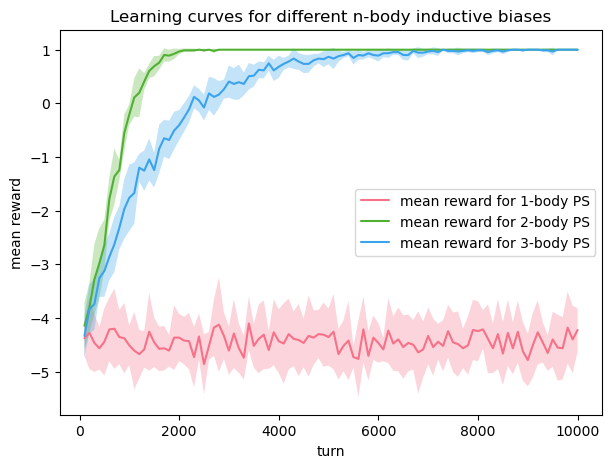

In [7]:
fig, ax = plt.subplots(figsize=(7.0, 5.0))
ax.set_xlabel('turn') 
ax.set_ylabel('mean reward')
colors = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):
    ax.plot(turns, means1, label='mean reward for 1-body PS', c = colors[0]) 
    ax.fill_between(turns, means1-stds1, means1+stds1 ,alpha=0.3, facecolor=colors[0])
    ax.plot(turns, means2, label='mean reward for 2-body PS', c = colors[1]) 
    ax.fill_between(turns, means2-stds2, means2+stds2 ,alpha=0.3, facecolor=colors[1])
    ax.plot(turns, means3, label='mean reward for 3-body PS', c = colors[2]) 
    ax.fill_between(turns, means3-stds3, means3+stds3 ,alpha=0.3, facecolor=colors[2])

ax.set_title("Learning curves for different n-body inductive biases")  
ax.legend();  
plt.savefig("./InvasionGame_training.png")
plt.show()

As expected, the 1-body cutoff agent is too simple: It cannot extract the correlations of the first two observables to make the right decision, because it can only look at one observable at a time.

The 2-body agent has exactly the right inductive bias: It can solve the environment perfectly, and learns the fastest.

The 3-body agent can still solve the environment, but it learns slower. It must learn separate h-values for each value of the third observable, despite the third observable being just a distraction.